# Week 2: Regularisation Methods

---

## Objectives

- Understand why ordinary least squares can overfit  
- Implement Ridge regression with cross‐validation  
- Implement Lasso regression with cross‐validation  
- Implement Elastic Net regression with cross‐validation  
- Compare model performance and coefficient shrinkage  

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

## Load and Inspect the Data

In [2]:
df = pd.read_csv('datasets/drsufi.csv')
df['AttackDate'] = pd.to_datetime(df['AttackDate'], format='%d/%m/%Y %H:%M')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77623 entries, 0 to 77622
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AttackDate            77623 non-null  datetime64[ns]
 1   Country               77623 non-null  object        
 2   Spam                  77623 non-null  float64       
 3   Ransomware            77623 non-null  float64       
 4   Local Infection       77623 non-null  float64       
 5   Exploit               77623 non-null  float64       
 6   Malicious Mail        77623 non-null  float64       
 7   Network Attack        77623 non-null  float64       
 8   On Demand Scan        77623 non-null  float64       
 9   Web Threat            77623 non-null  float64       
 10  Rank Spam             77623 non-null  int64         
 11  Rank Ransomware       77623 non-null  int64         
 12  Rank Local Infection  77623 non-null  int64         
 13  Rank Exploit    

### Brief EDA Summary

In [3]:
numeric_cols = [
    'Ransomware',
    'Local Infection',
    'Exploit',
    'Malicious Mail',
    'Network Attack',
    'On Demand Scan',
    'Web Threat'
]

df[numeric_cols].describe()

,Ransomware,Local Infection,Exploit,Malicious Mail,Network Attack,On Demand Scan,Web Threat
count,77623.000000,77623.000000,77623.000000,77623.000000,77623.000000,77623.000000,77623.000000
mean,0.000087,0.012807,0.000388,0.001152,0.002048,0.009330,0.012381
std,0.000164,0.008653,0.000379,0.001568,0.002973,0.006271,0.005568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.006730,0.000120,0.000190,0.000580,0.004850,0.009170
50%,0.000040,0.010470,0.000310,0.000590,0.001180,0.007840,0.012310
75%,0.000100,0.017200,0.000560,0.001510,0.002190,0.012560,0.015750
max,0.009180,0.049370,0.004660,0.043220,0.058260,0.124880,0.048630


## Motivation for Regularization
Ordinary least squares solves

$$
\min_{\beta}\sum_{i=1}^n (y_i - x_i^\top \beta)^2.
$$

When predictors are many, highly correlated, or $n$ is small relative to $p$, this can lead to overfitting. We add penalty terms to shrink coefficients:
- Ridge adds $ \lambda |\beta|_2^2$
- Lasso adds $ \lambda |\beta|_1$
- Elastic Net adds $ \lambda\bigl(\alpha|\beta|_1 + (1-\alpha)|\beta|_2^2\bigr)$

## Data Preparation

In [4]:
X = df[numeric_cols].values
y = df['Spam'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

##  Ridge Regression

We solve

$$
\min_{\beta}\sum_i (y_i - x_i^\top \beta)^2 + \lambda |\beta|_2^2.
$$

In [5]:
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
ridge_cv = GridSearchCV(ridge, param_grid, cv=5)
ridge_cv.fit(X_train, y_train)

best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

print("Ridge best alpha:", ridge_cv.best_params_['alpha'])
print(f"R^2 = {r2_score(y_test, y_pred_ridge):.3f}, MSE = {mean_squared_error(y_test, y_pred_ridge):.6f}")

Ridge best alpha: 100
R^2 = 0.067, MSE = 0.000426


### Predicted vs. True

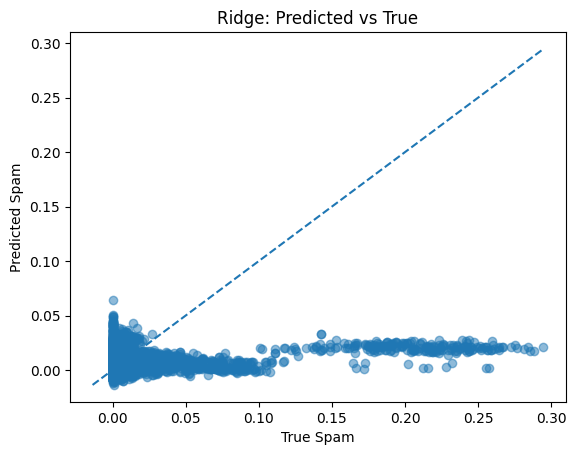

In [6]:
mn, mx = min(y_test.min(), y_pred_ridge.min()), max(y_test.max(), y_pred_ridge.max())

plt.figure()
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Ridge: Predicted vs True')
plt.show()

### Residual Diagnostics

((array([-4.01466637, -3.80033783, -3.6831357 , ...,  3.6831357 ,
          3.80033783,  4.01466637]),
  array([-0.06438262, -0.05069792, -0.04988832, ...,  0.2679157 ,
          0.27046505,  0.27378871])),
 (0.012293237097500551, -0.00015577666839848467, 0.5953407063300495))

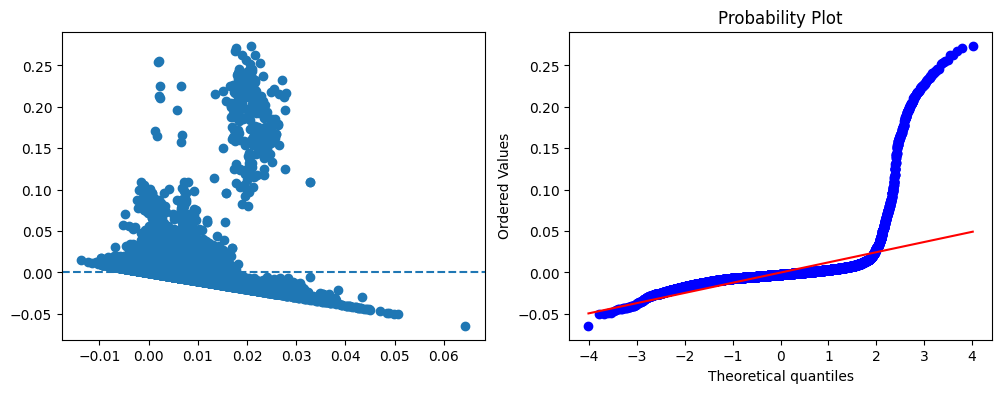

In [7]:
residuals = y_test - y_pred_ridge
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].scatter(y_pred_ridge, residuals); axes[0].axhline(0, linestyle='--')
stats.probplot(residuals, dist="norm", plot=axes[1])

---
## Lasso Regression

We solve

$$
\min_{\beta}\sum_i (y_i - x_i^\top \beta)^2 + \lambda |\beta|_1. 
$$

In [8]:
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X_train, y_train)

best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

print("Lasso best alpha:", lasso_cv.best_params_['alpha'])
print(f"R^2 = {r2_score(y_test, y_pred_lasso):.3f}, MSE = {mean_squared_error(y_test, y_pred_lasso):.6f}")
print("Nonzero coefficients:", np.sum(best_lasso.coef_ != 0))

Lasso best alpha: 1e-06
R^2 = 0.066, MSE = 0.000426
Nonzero coefficients: 7


### Predicted vs. True

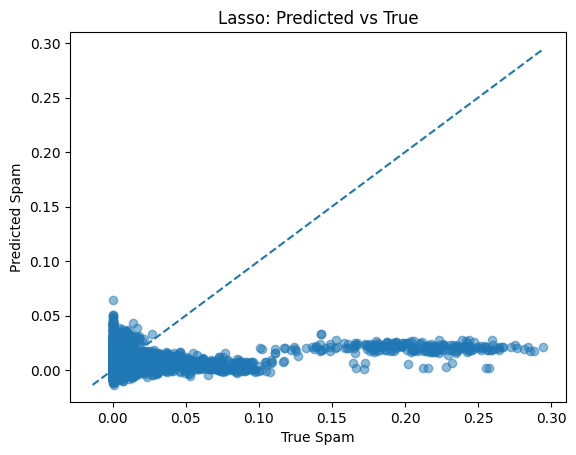

In [9]:
mn, mx = min(y_test.min(), y_pred_lasso.min()), max(y_test.max(), y_pred_lasso.max())

plt.figure()
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Lasso: Predicted vs True')
plt.show()

### Residual Analysis

((array([-4.01466637, -3.80033783, -3.6831357 , ...,  3.6831357 ,
          3.80033783,  4.01466637]),
  array([-0.06451673, -0.05079193, -0.05003197, ...,  0.2678942 ,
          0.27043644,  0.2737542 ])),
 (0.012300571825349096, -0.00015565129661324447, 0.5956932984279679))

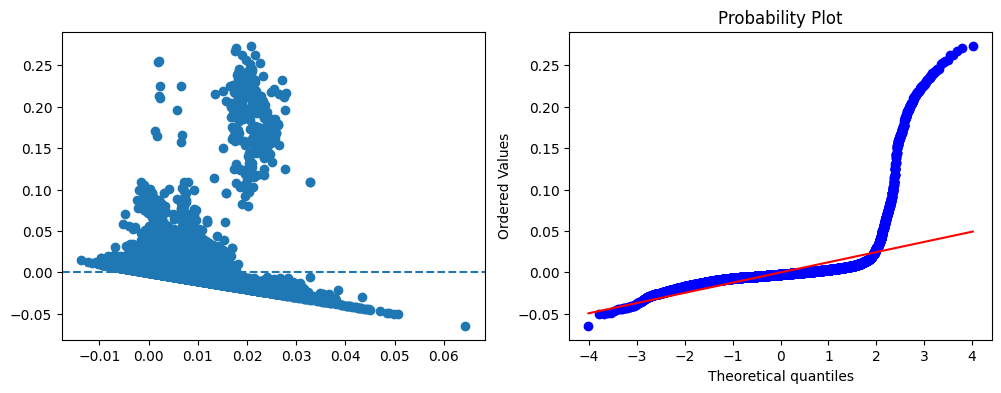

In [10]:
residuals = y_test - y_pred_lasso
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].scatter(y_pred_ridge, residuals); axes[0].axhline(0, linestyle='--')
stats.probplot(residuals, dist="norm", plot=axes[1])

## Elastic Net Regression

We solve

$$
\min_{\beta}\sum_i (y_i - x_i^\top \beta)^2 + \lambda\bigl(\alpha|\beta|_1 + (1-\alpha)|\beta|_2^2\bigr).
$$

In [11]:
enet = ElasticNet(max_iter=10000)
param_grid = {
    'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.2, 0.5, 0.8]
}
enet_cv = GridSearchCV(enet, param_grid, cv=5)
enet_cv.fit(X_train, y_train)

best_enet = enet_cv.best_estimator_
y_pred_enet = best_enet.predict(X_test)

print("Elastic Net best params:", enet_cv.best_params_)
print(f"R^2 = {r2_score(y_test, y_pred_enet):.3f}, MSE = {mean_squared_error(y_test, y_pred_enet):.6f}")

Elastic Net best params: {'alpha': 1e-05, 'l1_ratio': 0.2}
R^2 = 0.066, MSE = 0.000426


### Precited vs. True

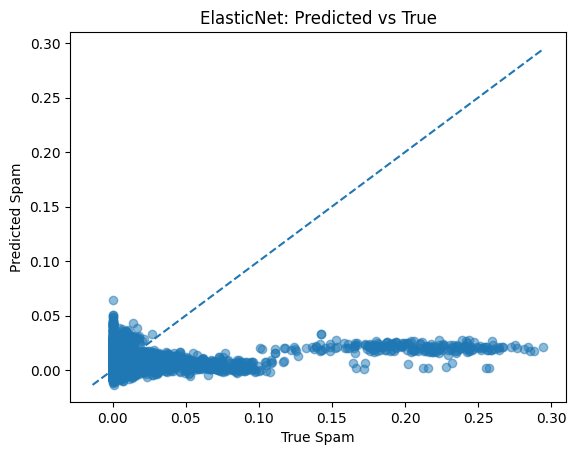

In [12]:
mn, mx = min(y_test.min(), y_pred_enet.min()), max(y_test.max(), y_pred_enet.max())

plt.figure()
plt.scatter(y_test, y_pred_enet, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('ElasticNet: Predicted vs True')
plt.show()

### Residual Analysis

((array([-4.01466637, -3.80033783, -3.6831357 , ...,  3.6831357 ,
          3.80033783,  4.01466637]),
  array([-0.06449688, -0.05077793, -0.04998292, ...,  0.26789573,
          0.2704446 ,  0.27376334])),
 (0.012299016774115545, -0.00015572740061173967, 0.5956167558090751))

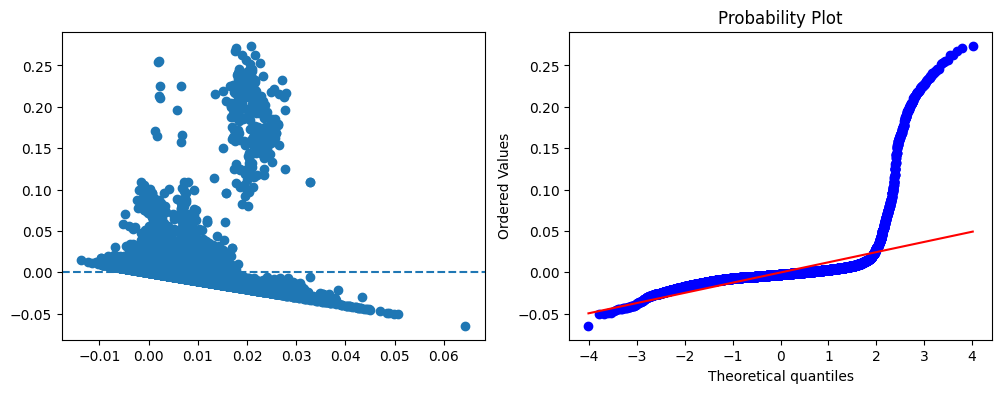

In [13]:
residuals = y_test - y_pred_enet
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].scatter(y_pred_ridge, residuals); axes[0].axhline(0, linestyle='--')
stats.probplot(residuals, dist="norm", plot=axes[1])

## Coefficient Paths

Visualise coefficient shrinkage in Lasso as we vary $\alpha$:

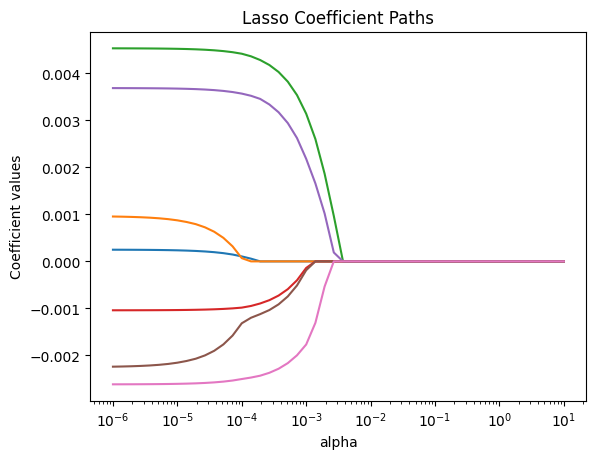

In [14]:
alphas = np.logspace(-6, 1, 50)
coefs = []
for a in alphas:
    model = Lasso(alpha=a, max_iter=10000).fit(X_train, y_train)
    coefs.append(model.coef_)

plt.figure()
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficient values')
plt.title('Lasso Coefficient Paths')
plt.show()

## Key Takeaways

| Model       | Best $\alpha$     | `l1_ratio` | Test $R^2$ | Test MSE   | Nonzero Coefs |
|-------------|------------------:|---------:|-----------:|-----------:|--------------:|
| Ridge       | $100 $              | –        | 0.0665    | 0.000426  | –             |
| Lasso       | $1\times10^{-5}$  | –        | 0.0665    | 0.000426  | 7             |
| Elastic Net | $1\times10^{-5}$  | 0.20     | 0.0660    | 0.000426  | –             |

- **Ridge** ($\alpha = 100$) and **Lasso** ($\alpha = 10^{-5}$) both achieved the highest test $R^2$ of approximately $0.0665$ with MSE = $0.000426$.  
- **Lasso** retained only 7 predictors, offering a more interpretable, sparse model without sacrificing accuracy.  
- **Elastic Net** ($\alpha = 10^{-5}$, l1_ratio = $0.20$) now matches Ridge and Lasso performance ($R^2 \approx 0.066$, MSE = $0.000426$), indicating that a small mixed penalty combines the benefits of both $L_1$ and $L_2$.  
- Regularisation provides modest gains over OLS, with sparse Lasso and mixed Elastic Net offering interpretability, and Ridge offering stability when predictors are correlated.  

## Yellowdig Contribution

https://yellowdig.app/n/bu-omds/community/680847e5-a19a-76a7-5e0e-1a1c8b27a7a3?postId=682cf7a9-c876-4102-b05b-bf86c3dbd72a